In [535]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots

В первом домашнем задании вам предлагается:

* Составить постановку задач машинного обучения языком математической статистики.
* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$. 
* Найти непрерывное распределение (если среднее $\mu$ и дисперсия $\sigma^2$ заданы), для которого информационная энтропия максимальна. Подсказка: воспользуйтесь методом множителей Лагранжа.

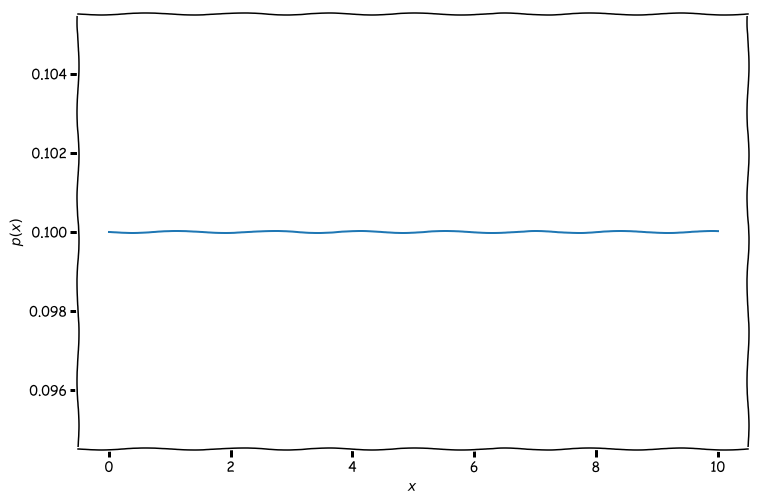

In [536]:
with plt.xkcd():
    plt.plot([0, 10], [0.1, 0.1])
    plt.ylabel('$p(x)$')
    plt.xlabel('$x$')

    plt.show()

* Для распределения, функция плотности которого изображена выше, найдите математическое ожидание и дисперсию.

$E(x) = \int_0^{10}x\cdot\frac{1}{10}\,\mathrm{d}x = \left.\left(\frac{x^2}{20}\right)\right|_0^{10}=5$

$V(x) = \int_0^{10}(x-5)^2\cdot\frac{1}{10}\,\mathrm{d}x = \int_{-5}^{5}t^2\cdot\frac{1}{10}\,\mathrm{d}t=
\left.\left(\frac{t^3}{30}\right)\right|_{-5}^{5}=\frac{25}{3}$

$\sigma=\frac{5}{\sqrt{3}}$

Формула Байеса:
$$ p(y|x) = \frac {p(x|y) p(y)} {p(x)}$$

* Решите задачу: Тест на лихорадку Эбола успешен в $95\%$ случаев. По статистике лихорадкой Эбола болеет один человек из ста. Если вы получили положительный результат теста, какова вероятность того, что вы действительно больны? 

Решения впишите на место этой ячейки. Для оформления можно (и нужно) воспользваоться [markdown](https://en.support.wordpress.com/markdown-quick-reference/) и формулами [TEX](https://en.wikibooks.org/wiki/LaTeX/Mathematics).

$P(болеет|тест+) = \frac{P\left(тест+|болеет\right) * P(болеет)}{P(тест+)} = 
\frac{P(тест+|болеет) * P(болеет)}{P(тест+|болеет) * P(болеет) + P(тест+|не\ болеет) * P(не\ болеет)} =
\frac{0.95 * 0.01}{0.95 * 0.01 + 0.05 * 0.99} = 0.161$

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [539]:
import numpy as np

In [540]:
from keras.datasets import cifar10
from random import randrange
import time

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [541]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [542]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

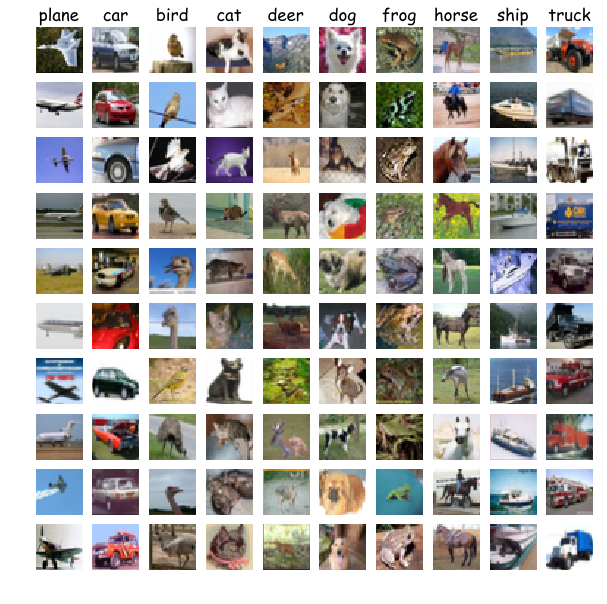

In [543]:
with plt.xkcd():
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 10
    plt.figure(figsize=(10,10))
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(x_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

In [544]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


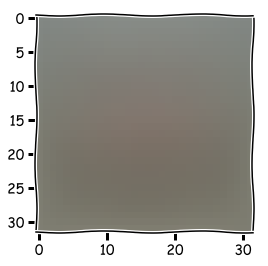

In [545]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
with plt.xkcd():
    plt.figure(figsize=(4,4))
    plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
    plt.show()

In [546]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [547]:
print(x_train.shape)

(50000, 3072)


In [548]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [549]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует [функция потерь SVM (hinge loss)](https://en.wikipedia.org/wiki/Hinge_loss), которую вам предстоит дописать.

In [550]:
import time

def svm_loss(W, X, y, reg, verbose = False):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов  ## num_classes x num_pixels
    - X: Данные        ###  num_obs x num_pixels
    - y: Целевой признак 
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    

    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    num_class = W.shape[0]
    num_obs = X.shape[0]
    num_vars = X.shape[1]
    
    delta = 1
    eps = 1e-10
    
    st = time.time()
    ## loss function
    dt_score = np.dot(X,np.transpose(W))
    score_true = dt_score[np.arange(0,num_obs),np.reshape(y,-1)]
    score_true = np.reshape(score_true,(-1,1))
    dt_loss = dt_score - score_true + delta
    dt_loss[np.arange(0,num_obs),np.reshape(y,-1)] = 0
    dt_loss[dt_loss<0] = 0
    loss = np.sum(dt_loss) / num_obs  + reg * np.sum(W*W) 
    
    dt_loss[dt_loss>0]=1
    
    if verbose: print ("time for loss",time.time()-st)

    ## Calculate dW
    ##
    st = time.time()       
    num_incorrect = np.sum(dt_loss,axis=1)
    dt_loss[np.arange(0,num_obs),np.reshape(y,-1)]= - num_incorrect
    dW = np.dot(np.transpose(X), dt_loss)
    dW = np.transpose(dW)
         
    if verbose: print ("time for gradient: ", time.time()-st)
    st = time.time()
    
    ## regularization
    dW = dW / num_obs + reg * 2*W 

    return loss, dW

In [551]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss(W, x_test, y_test, 0.000005, verbose = True)
print('loss: %f' % (loss, ))

time for loss 0.09023880958557129
time for gradient:  0.07770705223083496
loss: 9.079956


In [552]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [553]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print ("\nGradient with regularization")
# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -15.454526 analytic: -15.454650, relative error: 3.992851e-06
numerical: -2.345497 analytic: -2.347628, relative error: 4.540767e-04
numerical: -8.114687 analytic: -8.111842, relative error: 1.752859e-04
numerical: 12.234697 analytic: 12.234697, relative error: 1.316874e-12
numerical: 3.475840 analytic: 3.474222, relative error: 2.327077e-04
numerical: -4.419112 analytic: -4.422642, relative error: 3.991817e-04
numerical: -4.321492 analytic: -4.320016, relative error: 1.708180e-04
numerical: -13.287875 analytic: -13.290489, relative error: 9.834684e-05
numerical: -10.512416 analytic: -10.506841, relative error: 2.652249e-04
numerical: 9.746850 analytic: 9.744332, relative error: 1.291704e-04

Gradient with regularization
numerical: 2.638920 analytic: 2.642947, relative error: 7.623663e-04
numerical: 9.631283 analytic: 9.634519, relative error: 1.679430e-04
numerical: 16.031788 analytic: 16.025964, relative error: 1.816742e-04
numerical: -4.237876 analytic: -4.237788, relativ

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [554]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        
        idxs = np.arange(0,x_train.shape[0])
        sample_size = 200
        
        for it in range(num_iters):
            
            idxs_sample = np.random.choice(idxs, sample_size, replace=False)
            loss, grad = loss_grad_svm_vectorized(self.W, x_train[idxs_sample,:], y_train[idxs_sample], reg)
            self.W = self.W - learning_rate * grad
            loss_history.append(loss)
            if verbose and it % 100 == 1: 
               print('loss: %f' % (loss, ))    

        return loss_history
    
    def predict(self, X):
        y_pred = np.argmax(np.dot(X,np.transpose(self.W)),axis=1)
        y_pred = np.reshape(y_pred,(-1,1))
        return y_pred

Проверяем полученную реализацию.

In [555]:
tic = time.time()
svm = SVM()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=1500,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

loss: 8.095575
loss: 4.966466
loss: 5.365297
loss: 5.049557
loss: 4.477054
loss: 4.959020
loss: 4.666534
loss: 4.241763
loss: 4.866647
loss: 4.770319
loss: 4.342659
loss: 4.605729
loss: 4.538394
loss: 4.625864
loss: 4.793770
That took 11.151639s


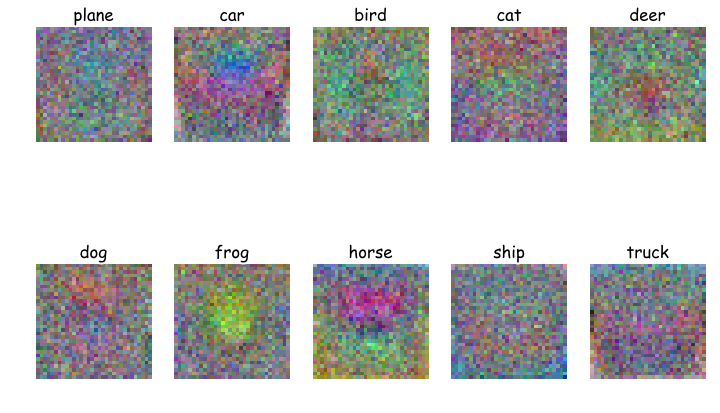

In [556]:
plot_weights(svm)

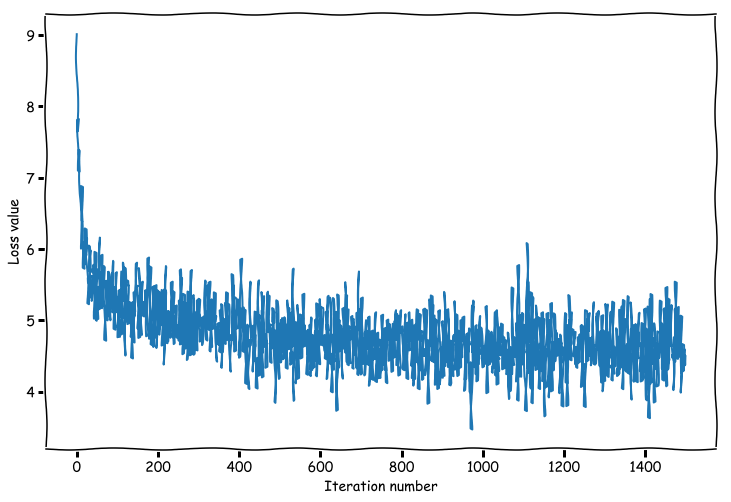

In [557]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
with plt.xkcd():
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

In [558]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.402160
validation accuracy: 0.387300


In [559]:
def plot_weights(best_svm):
    with plt.xkcd():
        w = best_svm.W[:,:-1] # strip out the bias
        w = w.reshape(10, 32, 32, 3)
        w_min, w_max = np.min(w), np.max(w)
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        for i in range(10):
            plt.subplot(2, 5, i + 1)

            # Rescale the weights to be between 0 and 255
            wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
            plt.imshow(wimg.astype('uint8'))
            plt.axis('off')
            plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

Loss 5.30, learning rate: 1.00E-06, regularization: 2500 
best:  1e-06 2500.0
Loss 5.49, learning rate: 1.00E-06, regularization: 25000 
Loss 7.54, learning rate: 1.00E-06, regularization: 250000 
Loss 5.09, learning rate: 1.00E-07, regularization: 2500 
best:  1e-07 2500.0
Loss 5.39, learning rate: 1.00E-07, regularization: 25000 
Loss 5.77, learning rate: 1.00E-07, regularization: 250000 
Loss 6.60, learning rate: 1.00E-08, regularization: 2500 
Loss 9.05, learning rate: 1.00E-08, regularization: 25000 
Loss 11.83, learning rate: 1.00E-08, regularization: 250000 


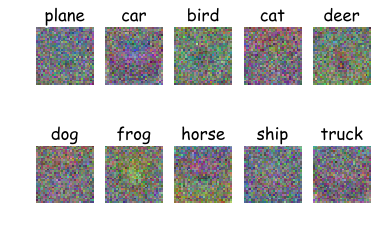

In [340]:

arr_learn_rate = [1e-6, 1e-7, 1e-8]
arr_reg = [2.5e3, 2.5e4,2.5e5]
best_svm = None
best_loss = 999999

for i_arr_learn_rate in arr_learn_rate:
    for i_arr_reg in arr_reg:
        svm = SVM()
        loss_hist = svm.train(x_train, y_train, learning_rate=i_arr_learn_rate, reg=i_arr_reg,
                              num_iters=400, verbose=False)
        
        print ("Loss %.2f, learning rate: %.2E, regularization: %d " % (loss_hist[-1], i_arr_learn_rate, i_arr_reg))
        if loss_hist[-1]<best_loss:
            best_loss= loss_hist[-1]
            best_svm = svm
            print ('best: ', i_arr_learn_rate, i_arr_reg)


plot_weights(best_svm)

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

- В основном классификация происходит по цвету изображения
- Визуально веса для каждого из классов выглядят, как шум
- Видны какие-то формы на отдельных картах, например, для car, но они не отчётливые

**Задача 5:** Повторим упражнение для [cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)

In [560]:
def crossentropy_loss(W, X, y, reg, verbose = False):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов (Classes x Vars)
    - X: Данные (Observations x Vars)
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    y = np.reshape(y,-1)
    
    num_class = W.shape[0]
    num_obs = X.shape[0]
    num_vars = X.shape[1]
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    ## Calculating softmax probabilities
    scores = X.dot(W.T)
    scores -= np.reshape(np.max(scores,axis=1),(-1,1))
    probs = np.exp(scores)
    probs = probs/ np.reshape(np.sum(probs,axis=1),(-1,1))
    prob_log = np.log(probs)
    
    loss = - np.sum(prob_log[np.arange(num_obs),y])/num_obs
    
    ## computing gradient
    ##
    probs = - probs
    probs[np.arange(num_obs),y] +=1
    dW = -np.dot(X.T,probs).T / num_obs
    
    ## regularization
    loss = loss + reg * np.sum(W*W)
    dW = dW + 2 * reg * W
    
    return loss, dW

In [561]:
# Вычисляем значение функции потерь и её градиент для W.
#W = np.random.randn(10, 3073) * 0.0001 

loss, grad = crossentropy_loss(W, x_test, y_test, 0.0, verbose = True)
print (loss)

2.358137463657296


In [562]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print (f'loss: {loss}')
print (f'sanity check: {(-np.log(0.1))}')

loss: 2.358137463657296
sanity check: 2.3025850929940455


**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

Случайное угадывание даёт вероятность примерно 1/10

In [563]:
W = np.random.randn(10, 3073) * 0.0001 


loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)
f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]

print ("Without regularization")
grad_numerical = grad_check_sparse(f, W, grad, 10)


print ("")
print ("With regularization")
W = np.random.randn(10, 3073) * 0.0001 
loss, grad = crossentropy_loss(W, x_test, y_test, 5e10)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e10)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Without regularization
numerical: 1.180212 analytic: 1.180212, relative error: 4.211128e-08
numerical: 0.186610 analytic: 0.186610, relative error: 1.245197e-07
numerical: -6.247862 analytic: -6.247862, relative error: 1.861171e-09
numerical: 1.065771 analytic: 1.065770, relative error: 4.022576e-08
numerical: -0.165989 analytic: -0.165989, relative error: 6.613598e-08
numerical: -0.936379 analytic: -0.936379, relative error: 2.527656e-08
numerical: 0.463994 analytic: 0.463994, relative error: 1.987490e-08
numerical: 0.959021 analytic: 0.959021, relative error: 4.350204e-08
numerical: 1.746433 analytic: 1.746433, relative error: 2.041490e-08
numerical: 0.257011 analytic: 0.257011, relative error: 2.311732e-07

With regularization
numerical: 5950155.036710 analytic: 5950155.036826, relative error: 9.697085e-12
numerical: -5494304.093439 analytic: -5494304.093440, relative error: 1.203499e-13
numerical: -10163233.122509 analytic: -10163233.122671, relative error: 7.960733e-12
numerical: 

In [564]:
class SoftMax():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        
        idxs = np.arange(0,x_train.shape[0])
        sample_size = 200
        
        for it in range(num_iters):
            
            idxs_sample = np.random.choice(idxs, sample_size, replace=False)
            loss, grad = crossentropy_loss(self.W, x_train[idxs_sample,:], y_train[idxs_sample], reg)
            self.W = self.W - learning_rate * grad
            loss_history.append(loss)
            if verbose and it % 100 == 1: 
               print('loss: %f' % (loss, ))    

        return loss_history
    
    def predict(self, X):
        y_pred = np.argmax(np.dot(X,np.transpose(self.W)),axis=1)
        y_pred = np.reshape(y_pred,(-1,1))
        return y_pred

In [565]:
tic = time.time()
smax = SoftMax()
loss_hist = smax.train(x_train, y_train, learning_rate=1e-7, reg=1500,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

loss: 2.833967
loss: 2.468153
loss: 2.420095
loss: 2.373805
loss: 2.306787
loss: 2.266763
loss: 2.196100
loss: 2.283086
loss: 2.263024
loss: 2.109420
loss: 2.063001
loss: 2.112798
loss: 2.113816
loss: 2.123575
loss: 2.016144
That took 12.219383s


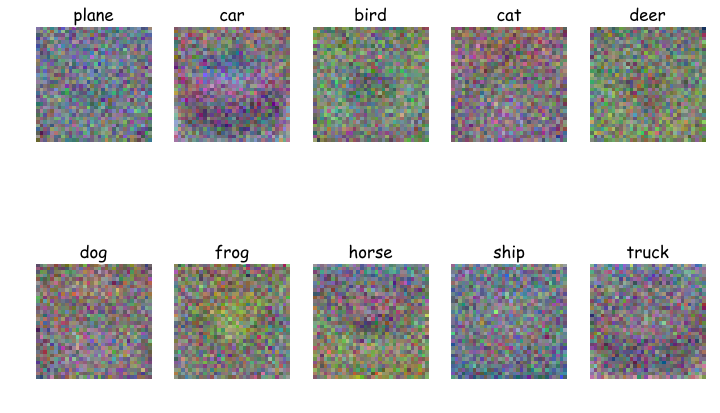

In [566]:
plot_weights(smax)

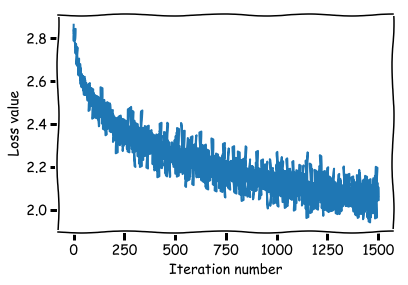

In [529]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
with plt.xkcd():
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

In [531]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.379320
validation accuracy: 0.378200
